In [3]:
import jax.numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import astropy.io.fits as pf
import xaosim as xs
from xaosim.pupil import PHARO
# from scipy.ndimage import rotate
import xara

%matplotlib inline

import matplotlib as mpl
mpl.style.use('seaborn-colorblind')
phasemap = mpl.cm.rainbow
phasemap.set_bad(color='k')


#To make sure we have always the same matplotlib settings
#(the ones in comments are the ipython notebook settings)

mpl.rcParams['figure.figsize']=(12.0,9.0)    #(6.0,4.0)
mpl.rcParams['font.size']=20               #10 
mpl.rcParams['savefig.dpi']= 200             #72 
mpl.rcParams['axes.labelsize'] = 18
mpl.rcParams['axes.labelsize'] = 18
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
from matplotlib import rc
mpl.rcParams["font.family"] = "Times New Roman"

colours = mpl.rcParams['axes.prop_cycle'].by_key()['color']


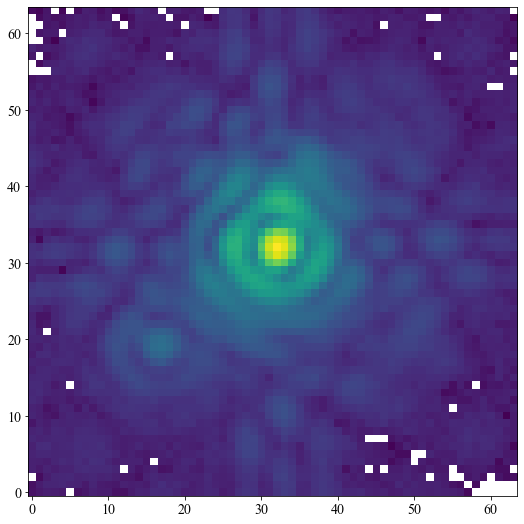

In [4]:
tgt_cube = pf.getdata('tgt_cube.fits') # alpha Ophiuchi
ca2_cube = pf.getdata('ca2_cube.fits') # epsilon Herculis

j = 0

plt.imshow(tgt_cube[j,:,:]**0.25)

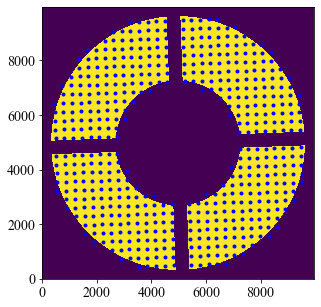

In [8]:

binary_model = False # use a finer transmission model for the aperture
PSZ     = 4978*2   # size of the array for the model
pdiam   = 4.978    # telescope diameter in meters
mstep   = 0.160    # step size in meters

pmask   = PHARO(PSZ, PSZ/2, mask="med")
pmask2  = PHARO(PSZ, PSZ/2, mask="med", ang=-2) # rotated!
ppscale = pdiam / PSZ

if binary_model:
        mtype="bina"
        p3k_model = xara.core.create_discrete_model(
                pmask, ppscale, mstep, binary=True, tmin=0.4)
else:
        mtype="grey"
        p3k_model = xara.core.create_discrete_model(
                pmask, ppscale, mstep, binary=False, tmin=0.05)
        p3k_model[:,2] = np.round(p3k_model[:,2],2)

# rotate the model by two degrees
# --------------------------------

th0 = -2.0 * np.pi / 180.0 # rotation angle
rmat = np.array([[np.cos(th0), -np.sin(th0)],
                                 [np.sin(th0), np.cos(th0)]])

p3k_model[:,:2] = p3k_model[:,:2].dot(rmat)

# -------------------------
#      simple plot
# -------------------------
f0 = plt.figure(0)
f0.clf()
ax = f0.add_subplot(111)
ax.imshow(pmask2)
ax.plot(PSZ/2+p3k_model[:,0]/ppscale,
                 PSZ/2+p3k_model[:,1]/ppscale, 'b.')
f0.set_size_inches(5,5, forward=True)

#f0.savefig("./imgs/PHARO/rotated_pupil.png")
# -------------------------


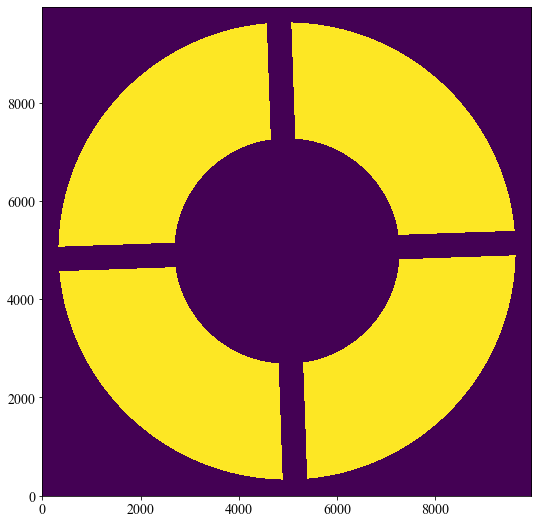

In [9]:
plt.imshow(pmask2)

Attempting to build KPI from array None
1362 distinct baselines were identified
1312 baselines were preserved after filtering
10 first singular values for this array:
[185.70474 185.69751 130.22834 130.22309  86.37561  86.3731   67.30037
  67.29565  44.92332  44.92221]

        Summary of properties for no_name
        ---------------------------------------------------------------
        - 528 sub-apertures
        - 1312 distinct baselines
        - 1048 Ker-phases (79.9 % target phase information recovery)
        - 264 Eig-phases (50.0 % wavefront information recovery)
        ---------------------------------------------------------------
        
KPI data successfully created
File provided is not a fits file
saving p3k_med_grey_model.fits
No kernel-phase data was included


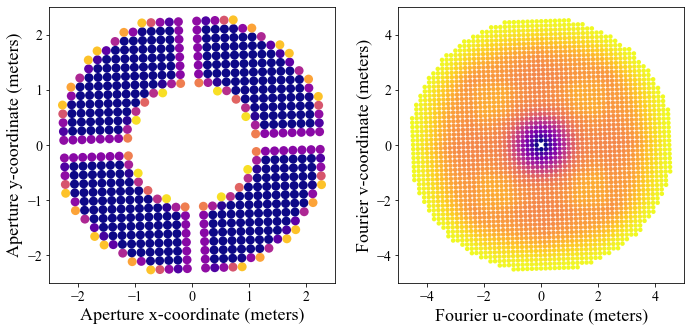

In [10]:
# compute the kernel-phase data structure
kpo_0 = xara.KPO(array=p3k_model, bmax=4.646)

# show side by side, the pupil model and its associated uv-coverage
kpo_0.kpi.plot_pupil_and_uv(xymax=2.5, cmap=cm.plasma_r, ssize=9, figsize=(10,5), marker='o')

# and save to a multi-extension kernel-phase fits file for later use
fname = "p3k_med_%s_model.fits" % (mtype,)
print("saving %s" % (fname,))
kpo_0.save_as_fits(fname)


In [5]:
# kpo1   = xara.KPO(fname="p3k_med_grey_model.fits")


/Users/benjaminpope/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in power
  


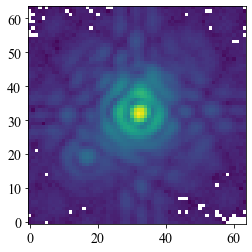

In [13]:
tgt_cube = pf.getdata('tgt_cube.fits') # alpha Ophiuchi
ca2_cube = pf.getdata('ca2_cube.fits') # epsilon Herculis

j = 0

plt.imshow(tgt_cube[j,:,:]**0.25)

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as pf
import xara

pscale = 25.0              # plate scale of the image in mas/pixels
wl     = 2.145e-6          # central wavelength in meters (Hayward paper)
ISZ    = tgt_cube.shape[1] # image size
kpo1   = xara.KPO(fname="p3k_med_grey_model.fits")
kpo2   = kpo1.copy()

kpo1.extract_KPD_single_cube(
        tgt_cube, pscale, wl,target="alpha Ophiuchi", recenter=True)
kpo2.extract_KPD_single_cube(
        ca2_cube, pscale, wl, target="epsilon Herculis", recenter=True)


Attempting to load file p3k_med_grey_model.fits
KPI data successfully loaded
The file contains 0 data-sets
CWAVEL was not set
No covariance data available

Cube slice   1 / 100First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...
Done!
Cube slice 100 / 100
Cube slice   1 / 100First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...
Done!
Cube slice 100 / 100

/Users/benjaminpope/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in power
  """Entry point for launching an IPython kernel.


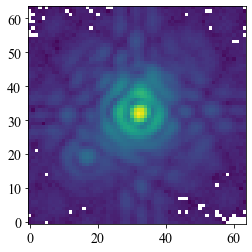

In [7]:
plt.imshow(tgt_cube[0,:,:]**0.25)

In [8]:
data1 = np.array(kpo1.KPDT)[0]
data2 = np.array(kpo2.KPDT)[0]

mydata = np.median(data1, axis=0) - np.median(data2, axis=0)
myerr  = np.sqrt(np.var(data1, axis=0) / (kpo1.KPDT[0].shape[0] - 1) + np.var(data2, axis=0) / (kpo2.KPDT[0].shape[0] - 1))
myerr = np.sqrt(myerr**2 + 1.2**2)


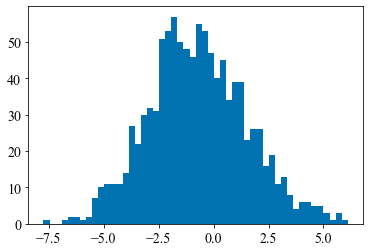

In [9]:
plt.hist(mydata,bins=50);

In [10]:
print("\ncomputing colinearity map...")
gsize = 100 # gsize x gsize grid
gstep = 10 # grid step in mas
xx, yy = np.meshgrid(
        np.arange(gsize) - gsize/2, np.arange(gsize) - gsize/2)
azim = -np.arctan2(xx, yy) * 180.0 / np.pi
dist = np.hypot(xx, yy) * gstep

#mmap = kpo1.kpd_binary_match_map(100, 10, mydata/myerr, norm=True)
mmap_raw = kpo1.kpd_binary_match_map(100, 10, np.median(data1, axis=0), norm=True)
mmap_calib = kpo1.kpd_binary_match_map(100, 10, np.median(data2, axis=0), norm=True)
mmap = kpo1.kpd_binary_match_map(100, 10, mydata, norm=True)

x0, y0 = np.argmax(mmap) % gsize, np.argmax(mmap) // gsize
print("max colinearity found for sep = %.2f mas and ang = %.2f deg" % (
        dist[y0, x0], azim[y0, x0]))



computing colinearity map...
max colinearity found for sep = 100.50 mas and ang = 84.29 deg


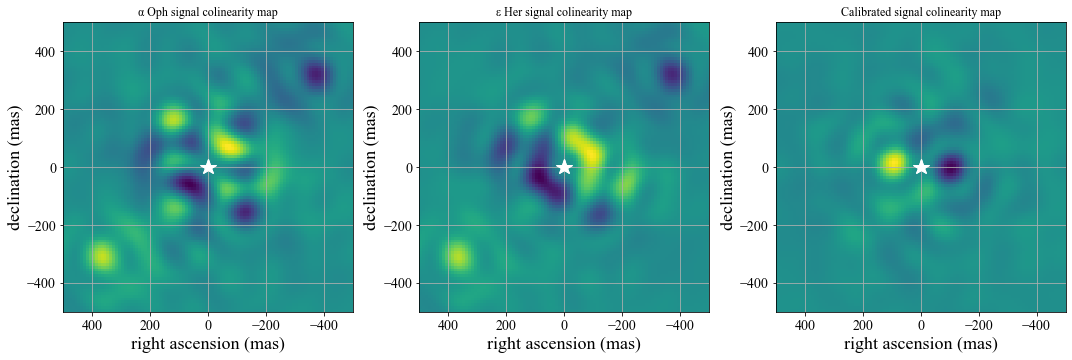

In [11]:

f1, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(15,5))
ax1.imshow(mmap_raw, extent=(
        gsize/2*gstep, -gsize/2*gstep, -gsize/2*gstep, gsize/2*gstep))
ax1.set_xlabel("right ascension (mas)")
ax1.set_ylabel("declination (mas)")
ax1.plot([0,0], [0,0], "w*", ms=16)
ax1.set_title("α Oph signal colinearity map")
ax1.grid()

ax2.imshow(mmap_calib, extent=(
        gsize/2*gstep, -gsize/2*gstep, -gsize/2*gstep, gsize/2*gstep))
ax2.set_xlabel("right ascension (mas)")
ax2.set_ylabel("declination (mas)")
ax2.plot([0,0], [0,0], "w*", ms=16)
ax2.set_title("ε Her signal colinearity map")
ax2.grid()

ax3.imshow(mmap, extent=(
        gsize/2*gstep, -gsize/2*gstep, -gsize/2*gstep, gsize/2*gstep))
ax3.set_xlabel("right ascension (mas)")
ax3.set_ylabel("declination (mas)")
ax3.plot([0,0], [0,0], "w*", ms=16)
ax3.set_title("Calibrated signal colinearity map")
ax3.grid()

f1.set_tight_layout(True)




computing colinearity map...
max colinearity found for sep = 100.50 mas and ang = 84.29 deg


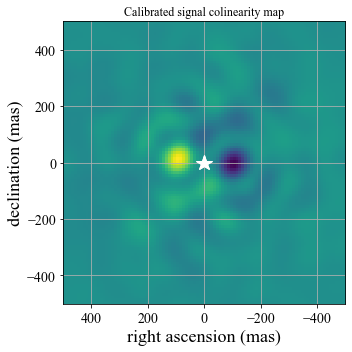

In [12]:
print("\ncomputing colinearity map...")
gsize = 100 # gsize x gsize grid
gstep = 10 # grid step in mas
xx, yy = np.meshgrid(
        np.arange(gsize) - gsize/2, np.arange(gsize) - gsize/2)
azim = -np.arctan2(xx, yy) * 180.0 / np.pi
dist = np.hypot(xx, yy) * gstep

#mmap = kpo1.kpd_binary_match_map(100, 10, mydata/myerr, norm=True)
mmap = kpo1.kpd_binary_match_map(100, 10, mydata, norm=True)
x0, y0 = np.argmax(mmap) % gsize, np.argmax(mmap) // gsize
print("max colinearity found for sep = %.2f mas and ang = %.2f deg" % (
        dist[y0, x0], azim[y0, x0]))

f1 = plt.figure(figsize=(5,5))
ax1 = f1.add_subplot(111)
ax1.imshow(mmap, extent=(
        gsize/2*gstep, -gsize/2*gstep, -gsize/2*gstep, gsize/2*gstep))
ax1.set_xlabel("right ascension (mas)")
ax1.set_ylabel("declination (mas)")
ax1.plot([0,0], [0,0], "w*", ms=16)
ax1.set_title("Calibrated signal colinearity map")
ax1.grid()
f1.set_tight_layout(True)
f1.canvas.draw()



binary model fitting...
sep = 124.557747, ang=86.550018, con=24.525299 => chi2 = 1.052
correlation matrix of parameters
[[ 2.63 -0.04 -1.17]
 [-0.04  0.21  0.01]
 [-1.17  0.01  0.94]]


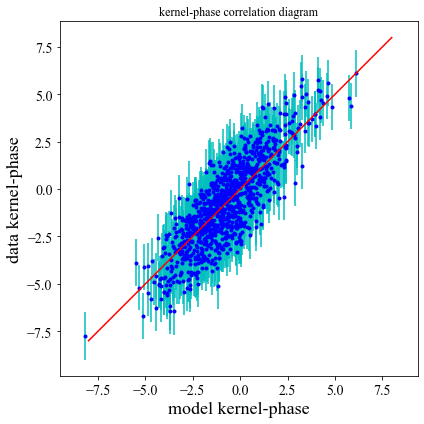

In [13]:
print("\nbinary model fitting...")
p0 = [dist[y0, x0], azim[y0, x0], mmap.max()] # good starting point

mfit = kpo1.binary_model_fit(p0, calib=kpo2)
p1 = mfit[0] # the best fit parameter vector (sep, P.A., contrast)

cvis_b = xara.core.cvis_binary(
        kpo1.kpi.UVC[:,0], kpo1.kpi.UVC[:,1], wl, p1) # binary
ker_theo = kpo1.kpi.KPM.dot(np.angle(cvis_b))

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)

ax.errorbar(ker_theo, mydata, yerr=myerr, fmt="none", ecolor='c')
ax.plot(ker_theo, mydata, 'b.')
mmax = np.round(np.abs(mydata).max())
ax.plot([-mmax,mmax],[-mmax,mmax], 'r')
ax.set_ylabel("data kernel-phase")
ax.set_xlabel("model kernel-phase")
ax.set_title('kernel-phase correlation diagram')
ax.axis("equal")
# ax.axis([-11, 11, -11, 11])
fig.set_tight_layout(True)

if myerr is not None:
        chi2 = np.sum(((mydata - ker_theo)/myerr)**2) / kpo1.kpi.nbkp
else:
        chi2 = np.sum(((mydata - ker_theo))**2) / kpo1.kpi.nbkp

print("sep = %3f, ang=%3f, con=%3f => chi2 = %.3f" % (p1[0], p1[1], p1[2], chi2))
print("correlation matrix of parameters")
print(np.round(mfit[1], 2))


In [14]:
p1

array([124.55774704,  86.55001767,  24.52529867])

In [15]:
print(kpo1.kpi.TFM.shape)
print(kpo1.kpi.VAC.shape)
print(kpo1.kpi.UVC.shape)

(1312, 527)
(528, 3)
(1312, 2)


In [15]:
# kpo1.kpd = mydata
# kpo1.plot_uv_map()

In [17]:
kpo1.kpi.VAC.shape

(528, 3)

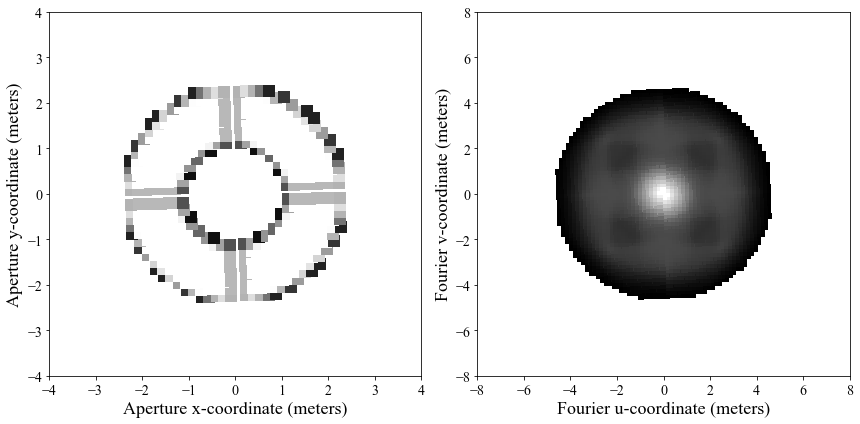

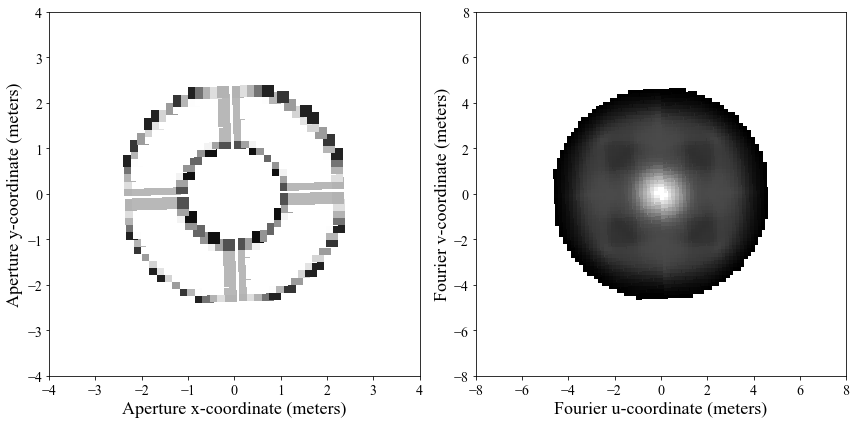

In [18]:
kpo1.kpi.plot_pupil_and_uv()

### Let's try emcee

In [19]:
import emcee

In [20]:
paramlimits=[40,250,0,360,1.1,50.]

def binary_model(params,kpo):
    u = kpo.kpi.UVC[:,0]
    v = kpo.kpi.UVC[:,1]
    wl = kpo.CWAVEL
    detpa = 0
    return(xara.core.cvis_binary(u,v,wl, params, detpa))

def kp_loglikelihood(params,kpo):
    temp = binary_model(params,kpo)
    model = kpo.kpi.KPM.dot(np.angle(temp))
    error = mydata-model
    error /= (myerr)
    chi2 = -np.sum((error)**2)
    return chi2 

def lnprior(params):
    if paramlimits[0] < params[0] < paramlimits[1] and paramlimits[2] < params[1] < paramlimits[3] and paramlimits[4] < params[2] < paramlimits[5]:
        return -np.log(params[0]) -np.log(params[2])
    return -np.inf

def lnprob(params,kpo):
    return lnprior(params) + kp_loglikelihood(params,kpo)

ndim=3
nwalkers=100
plot=False
burnin=100
nsteps=1000

import time


In [21]:
ivar = np.array(p0)  # initial parameters for model-fit

ball = np.array([ivar + 0.1*ivar*np.random.rand(ndim) for i in range(nwalkers)]) # initialise walkers in a ball

print('Running emcee now!')

t0 = time.time()

sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=[kpo1])

# burn in
pos,prob,state = sampler.run_mcmc(ball, burnin)
sampler.reset()

t1 = time.time()

print('Burnt in! Took %.3f seconds' %(t1-t0))


Running emcee now!
Burnt in! Took 50.202 seconds


In [22]:
# restart
sampler.run_mcmc(pos,nsteps)

tf = time.time()

print('Time elapsed = %.3f s' %(tf-t0))

seps = sampler.flatchain[:,0]
ths = sampler.flatchain[:,1]

meansep = np.mean(seps)
dsep = np.std(seps)

meanth = np.mean(ths)
dth = np.std(ths)

cs = sampler.flatchain[:,2]
bestcon = np.mean(cs)
conerr = np.std(cs)

print('Separation %.3f pm %.3f mas' % (meansep,dsep))
print('Position angle %.3f pm %.3f deg' % (meanth,dth))
print('Contrast at',wl,'um %.3f pm %.3f' % (bestcon,conerr))


Time elapsed = 550.586 s
Separation 121.926 pm 0.987 mas
Position angle 86.763 pm 0.253 deg
Contrast at 2.145e-06 um 24.691 pm 0.549


In [23]:
import corner

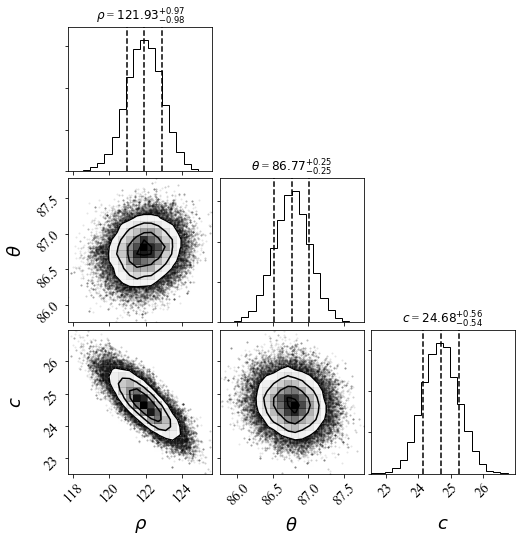

In [24]:
# Plot it.
figure = corner.corner(sampler.flatchain, labels=[r"$\rho$", r"$\theta$", r"$c$",],
                       quantiles=[0.16, 0.5, 0.84],
                       show_titles=True, title_kwargs={"fontsize": 12})


In [32]:
autodiff = np.loadtxt('autodiff.txt')

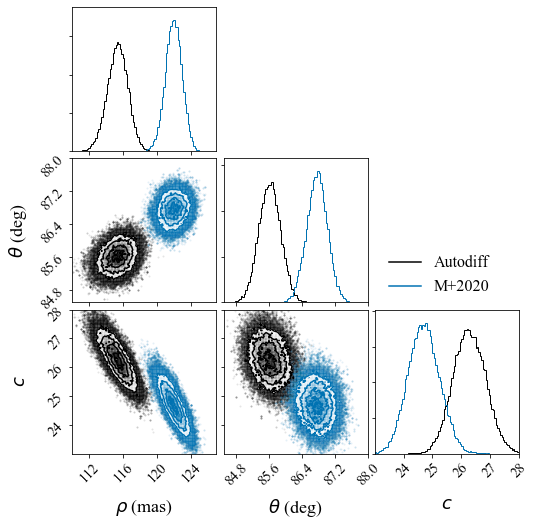

In [33]:
# Plot it.
import matplotlib.lines as mlines

# Plot it.
plotrange = ((110,127),(84.5,88),(23,28))
hist_kwargs = {}

figure = corner.corner(autodiff, range=plotrange, labels=[r"$\rho$ (mas)", r"$\theta$ (deg)", r"$c$",],
                       show_titles=False, title_kwargs={"fontsize": 12},color='k',bins=100,
                       scale_hist=True
                       )

corner.corner(sampler.flatchain, fig=figure,color=colours[0],range=plotrange,bins=100)


lines = [mlines.Line2D([], [], color='k', label='Autodiff'),mlines.Line2D([], [], color=colours[0], label='M+2020')]
plt.legend(handles=lines, bbox_to_anchor=(0., 1.0, 1., .0),fontsize=16,frameon=False);
plt.savefig('comparison_posterior.png',bbox_inches='tight')
plt.savefig('/Users/benjaminpope/code/morphine/paper/comparison_posterior.pdf',bbox_inches='tight')

### Let's look at the OTF

In [27]:
baselines = np.sqrt(np.sum(kpo2.kpi.UVC**2,axis=1))
theory_otf = kpo1.kpi.RED

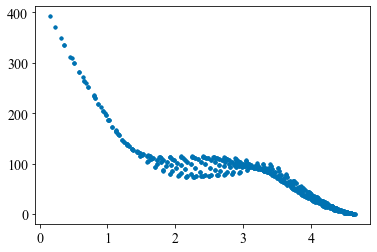

In [28]:
plt.plot(baselines,theory_otf,'.')

In [29]:
vis_frantz = np.median(kpo2.CVIS[0],axis=0)

/Users/benjaminpope/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


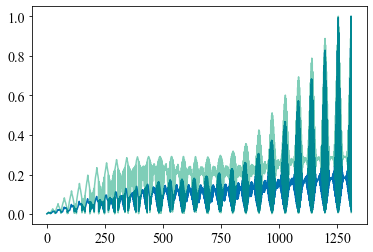

In [30]:
plt.plot(vis_frantz/vis_frantz.max())
plt.plot((theory_otf/theory_otf.max()),alpha=0.5)

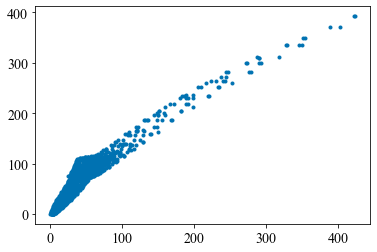

In [31]:
plt.plot(vis_frantz,theory_otf,'.')